In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])

In [2]:
SAVE_DIR = Path().cwd() # mes/paper_plots
DATA_DIR = Path().cwd().parent / "data" # mes/data
assert DATA_DIR.exists(), f"{DATA_DIR} does not exist"

## Plotting HPs

We'll want to make different figures for different kernel types, and dimensionality?

In [63]:
df = pd.read_json(DATA_DIR / "benchmark_df.json")

df["regret"] = df.apply(lambda x: x["y_true_max"] - np.array(x["y_max_history"]), axis=1)
df = df.drop(columns=["y_true_max", "final_y_max", "y_max_history"]) # cleanup rows
df = df.explode(["regret", "steps"], ignore_index=True) # explode history into seperate rows
df["regret"] = pd.to_numeric(df["regret"], errors="raise")

# mean regret over the `n_y` runs
cols2group = [c for c in df.columns if c not in {"run_id", "regret"}]
df = df.groupby(cols2group).agg(['mean', 'std', 'count', 'min']).drop(columns="run_id") # .reset_index()
df = df.reset_index().set_index(['kernel_type', 'n_dim', 'acq_func', 'steps'])
df

len_scale        lr     wd  \
                                                                          
kernel_type n_dim acq_func             steps                              
matern-3/2  2     expected_improvement 4            25  0.001000   0.00   
                                       4            25  0.001000   0.01   
                                       4            25  0.001000   0.10   
                                       4            25  0.001000   1.00   
                                       4            25  0.001000  10.00   
...                                                ...       ...    ...   
matern-5/2  4     ves_gamma            25           25  3.162278   0.00   
                                       25           25  3.162278   0.01   
                                       25           25  3.162278   0.10   
                                       25           25  3.162278   1.00   
                                       25           25  3.162278  10.00   

                                             max_iters    regret            \
                                                            mean       std   
kernel_type n_dim acq_func             steps                                 
matern-3/2  2     expected_improvement 4           200  1.022589  0.671469   
                                       4           200  1.022589  0.671469   
                                       4           200  1.022589  0.671469   
                                       4           200  1.022589  0.671469   
                                       4           200  1.022589  0.671469   
...                                                ...       ...       ...   
matern-5/2  4     ves_gamma            25          200  0.775044  0.341266   
                                       25          200  0.183350  0.254239   
                                       25          200  0.183350  0.254239   
                                       25          200  0.183350  0.254239   
                                       25          200  0.183350  0.254239   

                                                              
                                             count       min  
kernel_type n_dim acq_func             steps                  
matern-3/2  2     expected_improvement 4        10  0.000000  
                                       4        10  0.000000  
                                       4        10  0.000000  
                                       4        10  0.000000  
                                       4        10  0.000000  
...                                            ...       ...  
matern-5/2  4     ves_gamma            25       10  0.144186  
                                       25       10  0.000000  
                                       25       10  0.000000  
                                       25       10  0.000000  
                                       25       10  0.000000  

[5280 rows x 8 columns]

## Plotting the best HPs found.

Ok this is a bit huge...

Basically what we want to do is find the best config for each `["acq_func", "kernel_type", "n_dim"]`.

Hey did you know you could put a lambda in a `.loc[]` which is the df after all the previous operations? Mind blowing.

In [140]:
# our index is the config
index = ["kernel_type", "n_dim", "acq_func"]

hps_search = (
    df
    .xs('mean', level=1, axis=1).reset_index() # extract the mean regret from the multiple n_y
    .loc[lambda x: x.steps == x.steps.max()] # extract only the last step
    .drop(columns="steps") # drop columns (not needed)
    .loc[lambda x: x.groupby(index).regret.idxmin()] # get the argmin regret and index into it
    # .reset_index() # we would like to keep the original idx for this row
    .set_index(index)  # create MultiIndex, needed for plotting
)
hps_search

regret
kernel_type n_dim acq_func                      
matern-3/2  2     expected_improvement  0.007388
                  random_search         0.412350
                  ves_gamma             0.000000
            4     expected_improvement  0.368674
                  random_search         0.549059
                  ves_gamma             0.345687
matern-5/2  2     expected_improvement  0.031762
                  random_search         0.325915
                  ves_gamma             0.000000
            4     expected_improvement  0.051742
                  random_search         0.408777
                  ves_gamma             0.183350

In [65]:
df.index.get_level_values("acq_func").unique()

Index(['expected_improvement', 'random_search', 'ves_gamma'], dtype='object', name='acq_func')

This gives us a multi-index dataframe with unique keys of `(kernel_type, n_dim, acq_func, steps)` and mean, std, count regret for each row.

To index into a single kernel / dimension, we can use:

In [66]:
df.loc[('matern-3/2', 4)]

/var/folders/8l/m823kngj6n3fzx1hpgpv5f3c0000gq/T/ipykernel_69933/3358112588.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('matern-3/2', 4)]


len_scale        lr     wd max_iters    regret  \
                                                                     mean   
acq_func             steps                                                  
expected_improvement 4            25  0.001000   0.00       200  1.400413   
                     4            25  0.001000   0.01       200  1.400413   
                     4            25  0.001000   0.10       200  1.400413   
                     4            25  0.001000   1.00       200  1.400413   
                     4            25  0.001000  10.00       200  1.400413   
...                              ...       ...    ...       ...       ...   
ves_gamma            25           25  3.162278   0.00       200  0.345687   
                     25           25  3.162278   0.01       200  0.553231   
                     25           25  3.162278   0.10       200  0.553231   
                     25           25  3.162278   1.00       200  0.553231   
                     25           25  3.162278  10.00       200  0.553231   

                                                      
                                 std count       min  
acq_func             steps                            
expected_improvement 4      0.513646    10  0.413178  
                     4      0.513646    10  0.413178  
                     4      0.513646    10  0.413178  
                     4      0.513646    10  0.413178  
                     4      0.513646    10  0.413178  
...                              ...   ...       ...  
ves_gamma            25     0.395035    10  0.000000  
                     25     0.535972    10  0.000000  
                     25     0.535972    10  0.000000  
                     25     0.535972    10  0.000000  
                     25     0.535972    10  0.000000  

[1320 rows x 8 columns]

/Users/tomp/work/mes/paper_plots/benchmark-matern-3_2.png


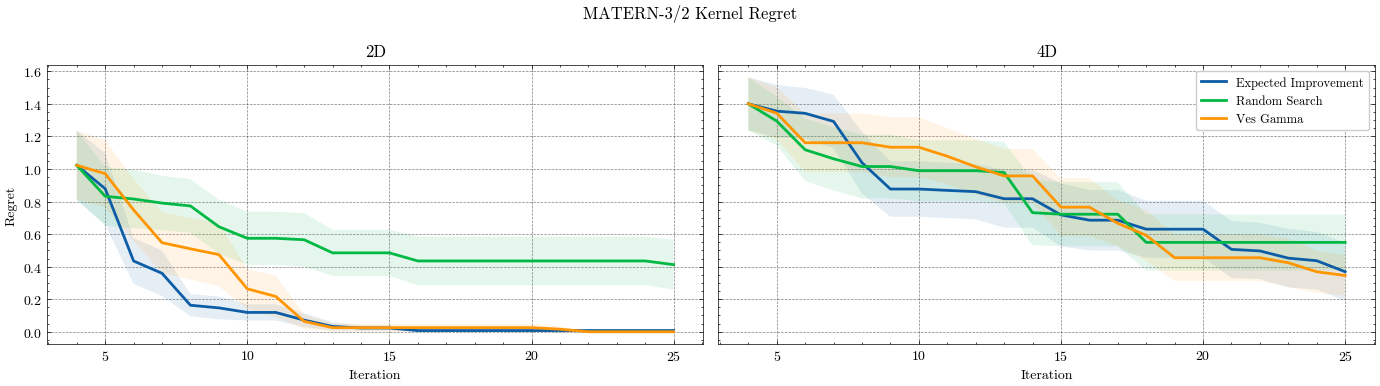

/Users/tomp/work/mes/paper_plots/benchmark-matern-5_2.png


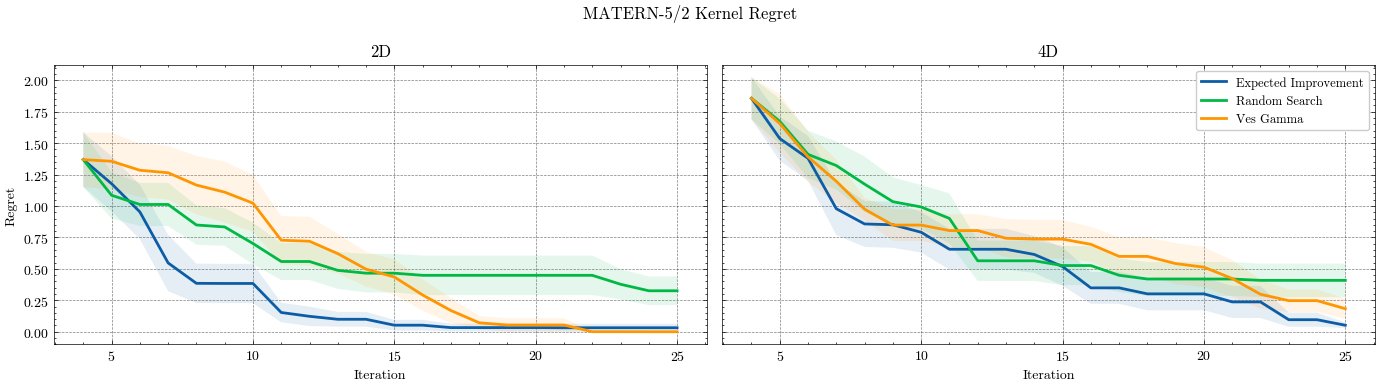

In [ ]:
def plot_best_lines(df, hps_search, save_dir=None):
    # flatten columns -> 'regret_mean', etc.
    flat = df.copy()
    if isinstance(flat.columns, pd.MultiIndex):
        flat.columns = ['_'.join(map(str, c)).strip('_') for c in flat.columns]
    flat = flat.reset_index()

    for kt, kdf in flat.groupby('kernel_type'):
        n_dims = sorted(kdf['n_dim'].unique())
        fig, axes = plt.subplots(1, len(n_dims), figsize=(14, 4), sharey=True)
        if len(n_dims) == 1: axes = [axes]

        for ax, nd in zip(axes, n_dims):
            sub = kdf.query("n_dim == @nd")
            for acq in sorted(sub['acq_func'].unique()):
                idx = int(hps_search.loc[(kt, nd, acq), 'index'])
                row = flat.iloc[idx]
                lr_v, wd_v = row['lr'], row['wd'] # best lr and wd

                best = sub.query("acq_func == @acq and lr == @lr_v and wd == @wd_v").sort_values('steps')

                x, y = best['steps'].to_numpy(), best['regret_mean'].to_numpy()
                ax.plot(x, y, label=acq.replace('_',' ').title(), linewidth=2)

                se = best['regret_std'].to_numpy() / np.sqrt(best['regret_count'].to_numpy())
                ax.fill_between(x, y - se, y + se, alpha=0.1)

                # if acq == 'ves_gamma' and 'regret_min' in best.columns:
                #     ax.plot(x, best['regret_min'].to_numpy(), '--', label=f"{acq.title()} Min", linewidth=2)

            ax.set_title(f"{nd}D")
            ax.set_xlabel("Iteration")
        axes[0].set_ylabel("Regret")
        axes[-1].legend(fontsize=9)
        fig.suptitle(f"{kt.upper()} Kernel Regret")
        plt.tight_layout()
        if save_dir:
            p = Path(save_dir) / f"benchmark-{kt.replace('/','_')}.png"
            fig.savefig(p, dpi=300)
            print(p)
        plt.show()

plot_best_lines(df, hps_search, save_dir=SAVE_DIR)